**<center><span style="color:blue">Importar Librerias</span></center>**
*****

In [1]:
import pandas as pd
import numpy as np
import sympy
import os
from pathlib import Path
from threading import Thread, Event
from tqdm import tqdm
import json
import datetime
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
plt.style.use("ggplot") 

**<span style="color:blue">Nata:</span>**<br>
- <span style="color:gray">Es necesario tener instalado el software **RoboDK**</span><br>

In [3]:
# Instalar librerias con el Kernel de RoboDK ---> Ejemplo ---> (c:/RoboDK/Python37/python.exe -m pip install sympy)
#
#
from robolink import *    # API to communicate with RoboDK
from robodk import *      # robodk robotics toolbox

In [4]:
# >> Ruta del proyecto
#
module_path = os.path.abspath(os.getcwd())

In [5]:
output_path = "./Output"
if not os.path.isdir(output_path): os.mkdir(output_path)
robot_1_output = os.path.join(output_path, "Robot-1")
robot_2_output = os.path.join(output_path, "Robot-2")
if not os.path.isdir(robot_1_output): os.mkdir(robot_1_output)
if not os.path.isdir(robot_2_output): os.mkdir(robot_2_output)

##### **<center><span style="color:blue">Funciones y Clases Auxliares</span></center>**
*****

In [6]:
# >> Imprimir en consola
#
#
def prRed(skk): return("\033[1;91m {}\033[00m" .format(skk))

def prGreen(skk): return("\033[1;92m {}\033[00m" .format(skk))
 
def prYellow(skk): return("\033[1;93m {}\033[00m" .format(skk))
 
def prLightPurple(skk): return("\033[1;94m {}\033[00m" .format(skk))
 
def prPurple(skk): return("\033[1;95m {}\033[00m" .format(skk))
 
def prCyan(skk): return("\033[1;96m {}\033[00m" .format(skk))
 
def prLightGray(skk): return("\033[97m {}\033[00m" .format(skk))
 
def prBlack(skk): return("\033[1;98m {}\033[00m" .format(skk))

cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#FFFFE0")]
}
index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: darkgrey; font-weight:normal;"
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #800000; color: white;"
}

In [7]:
# >> Creamos una clase para escritura y le lectura de archivos
#
# Version 2.1
class Files():
    def __init__(self, parent = None):
        self.parent = parent
    # Version 1.2
    def is_file_in_use(self, file_path):
        path = Path(file_path)
        if not path.exists():
            return False
        try:
            path.rename(path)
        except PermissionError:
            return True
        else:
            return False
    # Version 1.2
    def write_file(self, file_path, data=[], type_mode="w"):
        __run = True
        while __run:
            __status = False
            if os.path.isfile(file_path):
                __status = self.is_file_in_use(file_path=file_path)
            if not __status:
                try:
                    __file_input = open(file_path, type_mode, encoding="utf-8", errors="replace")
                    for __value in data:
                        __value = str(__value).replace("\n", "")
                        __file_input.write(str(__value) + "\n")
                    __file_input.close()
                    __run = False
                    break
                except:
                    print("Error...")
    # Version 1
    def readSingleLineFile(self, __filepath):
        __sline = ""
        __file = open(__filepath, "r", encoding="utf-8", errors="replace")
        __content = __file.readlines()
        __file.close()
        for __line in __content:
            if __line.find("#") != -1:
                pass
            else:
                if (__line == "") or (__line == "\n"):
                    pass
                else:
                    __sline = __line.replace("\n", "")
        return __sline
    # Version 1
    def readFile(self, filepath):
        __content = []
        __fullpath = os.path.abspath(str(filepath))
        if os.path.isfile(__fullpath):
            __ofile = open(__fullpath, "r", encoding="utf-8", errors="replace")
            __content = __ofile.readlines()
            __ofile.close()
        return __content
        # Version 1
    def readFileString(self, filepath):
        __content = ""
        __fullpath = os.path.abspath(str(filepath))
        if os.path.isfile(__fullpath):
            __ofile = open(__fullpath, "r", encoding="utf-8", errors="replace")
            __content = __ofile.read()
            __ofile.close()
        return __content
    # Version 1.2
    def write_file_string(self, file_path, data_string, type_mode="w"):
        __run = True
        while __run:
            __status = False
            if os.path.isfile(file_path):
                __status = self.is_file_in_use(file_path=file_path)
            if not __status:
                try:
                    __file_input = open(file_path, type_mode, encoding="utf-8", errors="replace")
                    __file_input.write(data_string)
                    __file_input.close()
                    __run = False
                except:
                    pass
            # time.sleep(3)

In [8]:
# >> Instanciar la clase Files()
files = Files()

*****

##### **<center><span style="color:blue">Denavit Hartemberg</span></center></br></br>**
**<center>Sistema de coordenadas del robot 6GDL</center>**<br><br>
*****
<center>
<div>
<img src="./Images/Sistema de coordenadas - Robot.png" width="600">
</div>
​<center>


**<span style="color:blue">Nata:</span>**<br>
- <span style="color:gray">Unidades en mm</span><br>
- **Comenzaremos el trabajo desde la descripción de Denavit-Hartenberg para el robot con 6GDL.**

**<center>Tabla de Denavit-Hartemberg</center>**

<center>   

| link | $\bm{\theta_{i-1}}$ | $\bm{d_{i-1}}$ | $\bm{\alpha_{i-1}}$ | $\bm{a_{i-1}}$| 
| ---: | ---: | ---: | ---: | ---: |
|  1  |  0  | 505 | 150 | -90 |
|  2  |  90 |   0 |-760 |  0  |
|  3  |  0  |   0 |-200 |  90 |
|  4  |  0  |1082 |   0 | -90 |
|  5  |  0  |   0 |   0 |  90 |
|  6  |  0  | 100 |   0 |  0  |
|  7  |  0  | 340 |   0 | -89 |

</center>
<!-- </div> -->

******

*****

##### **<center><span style="color:blue">Matriz de Transformación Homegenea</span></center>**
*****

In [9]:
# Definimos una función para construir las matrices de transformación
# en forma simbóĺica a partir de los parámetros D-H

def MatrixfromDH(theta, d, a, alpha):
    # theta y alpha en radianes
    # d y a en metros
    Rz = sympy.Matrix([[sympy.cos(theta), -sympy.sin(theta), 0, 0],
                   [sympy.sin(theta), sympy.cos(theta), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    tz = sympy.Matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, d],
                   [0, 0, 0, 1]])
    ta = sympy.Matrix([[1, 0, 0, a],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    Rx = sympy.Matrix([[1, 0, 0, 0],
                   [0, sympy.cos(alpha), -sympy.sin(alpha), 0],
                   [0, sympy.sin(alpha), sympy.cos(alpha), 0],
                   [0, 0, 0, 1]])
    return Rz*tz*ta*Rx

# y definimos una función para obtener la matriz de transformación desde una pose

def matrixFromPose(pose):
    # pose = [x, y, z, alpha, beta, gamma]
    # x, y, z en metros
    # alpha, beta, gamma en radianes
    x, y, z = pose[0], pose[1], pose[2]
    alpha, beta, gamma = pose[3], pose[4], pose[5]
    Ra = sympy.Matrix([[1, 0, 0, 0],
                   [0, sympy.cos(alpha), -sympy.sin(alpha), 0],
                   [0, sympy.sin(alpha), sympy.cos(alpha), 0],
                   [0, 0, 0, 1]])
    Rb = sympy.Matrix([[sympy.cos(beta), 0, sympy.sin(beta), 0],
                   [0, 1, 0, 0],
                   [-sympy.sin(beta), 0, sympy.cos(beta), 0],
                   [0, 0, 0, 1]])
    Rc = sympy.Matrix([[sympy.cos(gamma), -sympy.sin(gamma), 0, 0],
                   [sympy.sin(gamma), sympy.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    T = Ra*Rb*Rc
    T[0,3] = x
    T[1,3] = y
    T[2,3] = z
    return T

<center><span style="color:gray">Para describir la geometría espacial de un manipulador robótico en representación de coordenadas homogéneas 
sobre el espacio Euclidiano, es necesario recordar la matriz de transformación homogénea descrita por 
representación de Denavit-Hartenberg, la cual establece de manera sistemática, una metodología para 
asignar un sistema de coordenadas a cada elemento de la cadena articulada. Dicha representación, está descritaen la siguiente ecuación y representa el movimiento en cada eslabón en la articulación con respecto al sistema de 
coordenadas del elemento previo.</span></center>

<center>
<div>
<img src="./Images/Matriz de tranformacion Homegenea.png" width="600">
</div>
​<center>

In [10]:
# >> Matrices de tranformacion por cada eslabon
q1, q2, q3, q4, q5, q6 = sympy.symbols(['q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
# q1, q2, q3, q4, q5, q6 = np.array([-40.46, -35.37, -40.23, -54.89, -83.44, -148.68]) * (np.pi/180)
join1 = MatrixfromDH(q1, 0, 150, -sympy.pi/2)
join2 = MatrixfromDH(sympy.pi/2 + q2, 0, -760, 0)
join3 = MatrixfromDH(-q3, 0, -200, sympy.pi/2)
join4 = MatrixfromDH(-q4, 1082, 0, -sympy.pi/2)
join5 = MatrixfromDH(-q5, 0, 0, sympy.pi/2)
join6 = MatrixfromDH(-q6, 100, 0, 0)
# >> Pistola de Soldadura
join7 = MatrixfromDH(0, 340, -89, 0)

In [11]:
Ti = sympy.simplify(join1 * join2 * join3 * join4 * join5 * join6 * join7)
Ti

Matrix([
[ ((sin(q1)*sin(q4) - sin(q2 - q3)*cos(q1)*cos(q4))*cos(q5) + sin(q5)*cos(q1)*cos(q2 - q3))*cos(q6) + (sin(q1)*cos(q4) + sin(q4)*sin(q2 - q3)*cos(q1))*sin(q6),  ((sin(q1)*sin(q4) - sin(q2 - q3)*cos(q1)*cos(q4))*cos(q5) + sin(q5)*cos(q1)*cos(q2 - q3))*sin(q6) - (sin(q1)*cos(q4) + sin(q4)*sin(q2 - q3)*cos(q1))*cos(q6), (-sin(q1)*sin(q4) + sin(q2 - q3)*cos(q1)*cos(q4))*sin(q5) + cos(q1)*cos(q5)*cos(q2 - q3), -440*sin(q1)*sin(q4)*sin(q5) - 89*sin(q1)*sin(q4)*cos(q5)*cos(q6) - 89*sin(q1)*sin(q6)*cos(q4) + 760*sin(q2)*cos(q1) - 89*sin(q4)*sin(q6)*sin(q2 - q3)*cos(q1) + 440*sin(q5)*sin(q2 - q3)*cos(q1)*cos(q4) - 89*sin(q5)*cos(q1)*cos(q6)*cos(q2 - q3) + 89*sin(q2 - q3)*cos(q1)*cos(q4)*cos(q5)*cos(q6) + 200*sin(q2 - q3)*cos(q1) + 440*cos(q1)*cos(q5)*cos(q2 - q3) + 1082*cos(q1)*cos(q2 - q3) + 150*cos(q1)],
[-((sin(q1)*sin(q2 - q3)*cos(q4) + sin(q4)*cos(q1))*cos(q5) - sin(q1)*sin(q5)*cos(q2 - q3))*cos(q6) + (sin(q1)*sin(q4)*sin(q2 - q3) - cos(q1)*cos(q4))*sin(q6), -((sin(q1)*sin(q2 - q3

In [12]:
# Simplificamos la matriz para ocuparnos únicamente de las posiciones
T = matrixFromPose([Ti[3], Ti[7], Ti[11], 0, 0, 0])
T = sympy.simplify(T)
T

Matrix([
[1, 0, 0, -440*sin(q1)*sin(q4)*sin(q5) - 89*sin(q1)*sin(q4)*cos(q5)*cos(q6) - 89*sin(q1)*sin(q6)*cos(q4) + 760*sin(q2)*cos(q1) - 89*sin(q4)*sin(q6)*sin(q2 - q3)*cos(q1) + 440*sin(q5)*sin(q2 - q3)*cos(q1)*cos(q4) - 89*sin(q5)*cos(q1)*cos(q6)*cos(q2 - q3) + 89*sin(q2 - q3)*cos(q1)*cos(q4)*cos(q5)*cos(q6) + 200*sin(q2 - q3)*cos(q1) + 440*cos(q1)*cos(q5)*cos(q2 - q3) + 1082*cos(q1)*cos(q2 - q3) + 150*cos(q1)],
[0, 1, 0,  760*sin(q1)*sin(q2) - 89*sin(q1)*sin(q4)*sin(q6)*sin(q2 - q3) + 440*sin(q1)*sin(q5)*sin(q2 - q3)*cos(q4) - 89*sin(q1)*sin(q5)*cos(q6)*cos(q2 - q3) + 89*sin(q1)*sin(q2 - q3)*cos(q4)*cos(q5)*cos(q6) + 200*sin(q1)*sin(q2 - q3) + 440*sin(q1)*cos(q5)*cos(q2 - q3) + 1082*sin(q1)*cos(q2 - q3) + 150*sin(q1) + 440*sin(q4)*sin(q5)*cos(q1) + 89*sin(q4)*cos(q1)*cos(q5)*cos(q6) + 89*sin(q6)*cos(q1)*cos(q4)],
[0, 0, 1,                                                                                                                                                                  

In [13]:
# Obtenemos las ecuaciones
equations = T[:3,3]
equations

Matrix([
[-440*sin(q1)*sin(q4)*sin(q5) - 89*sin(q1)*sin(q4)*cos(q5)*cos(q6) - 89*sin(q1)*sin(q6)*cos(q4) + 760*sin(q2)*cos(q1) - 89*sin(q4)*sin(q6)*sin(q2 - q3)*cos(q1) + 440*sin(q5)*sin(q2 - q3)*cos(q1)*cos(q4) - 89*sin(q5)*cos(q1)*cos(q6)*cos(q2 - q3) + 89*sin(q2 - q3)*cos(q1)*cos(q4)*cos(q5)*cos(q6) + 200*sin(q2 - q3)*cos(q1) + 440*cos(q1)*cos(q5)*cos(q2 - q3) + 1082*cos(q1)*cos(q2 - q3) + 150*cos(q1)],
[ 760*sin(q1)*sin(q2) - 89*sin(q1)*sin(q4)*sin(q6)*sin(q2 - q3) + 440*sin(q1)*sin(q5)*sin(q2 - q3)*cos(q4) - 89*sin(q1)*sin(q5)*cos(q6)*cos(q2 - q3) + 89*sin(q1)*sin(q2 - q3)*cos(q4)*cos(q5)*cos(q6) + 200*sin(q1)*sin(q2 - q3) + 440*sin(q1)*cos(q5)*cos(q2 - q3) + 1082*sin(q1)*cos(q2 - q3) + 150*sin(q1) + 440*sin(q4)*sin(q5)*cos(q1) + 89*sin(q4)*cos(q1)*cos(q5)*cos(q6) + 89*sin(q6)*cos(q1)*cos(q4)],
[                                                                                                                                                                              -89*sin(q4)*si

*****

##### **<center><span style="color:blue">Derivadas parciales</span></center>**
*****

In [14]:
# Obtenemos la funcion Jacobiana
jacobian = equations.jacobian([q1, q2, q3])
jacobian

Matrix([
[-760*sin(q1)*sin(q2) + 89*sin(q1)*sin(q4)*sin(q6)*sin(q2 - q3) - 440*sin(q1)*sin(q5)*sin(q2 - q3)*cos(q4) + 89*sin(q1)*sin(q5)*cos(q6)*cos(q2 - q3) - 89*sin(q1)*sin(q2 - q3)*cos(q4)*cos(q5)*cos(q6) - 200*sin(q1)*sin(q2 - q3) - 440*sin(q1)*cos(q5)*cos(q2 - q3) - 1082*sin(q1)*cos(q2 - q3) - 150*sin(q1) - 440*sin(q4)*sin(q5)*cos(q1) - 89*sin(q4)*cos(q1)*cos(q5)*cos(q6) - 89*sin(q6)*cos(q1)*cos(q4), -89*sin(q4)*sin(q6)*cos(q1)*cos(q2 - q3) + 89*sin(q5)*sin(q2 - q3)*cos(q1)*cos(q6) + 440*sin(q5)*cos(q1)*cos(q4)*cos(q2 - q3) - 440*sin(q2 - q3)*cos(q1)*cos(q5) - 1082*sin(q2 - q3)*cos(q1) + 760*cos(q1)*cos(q2) + 89*cos(q1)*cos(q4)*cos(q5)*cos(q6)*cos(q2 - q3) + 200*cos(q1)*cos(q2 - q3), 89*sin(q4)*sin(q6)*cos(q1)*cos(q2 - q3) - 89*sin(q5)*sin(q2 - q3)*cos(q1)*cos(q6) - 440*sin(q5)*cos(q1)*cos(q4)*cos(q2 - q3) + 440*sin(q2 - q3)*cos(q1)*cos(q5) + 1082*sin(q2 - q3)*cos(q1) - 89*cos(q1)*cos(q4)*cos(q5)*cos(q6)*cos(q2 - q3) - 200*cos(q1)*cos(q2 - q3)],
[-440*sin(q1)*sin(q4)*sin(q5) - 89*

*****

##### **<center><span style="color:blue">Newton Raphson</span></center>**

*****

**<span style="color:blue">Nata:</span>**<br>
- <span style="color:gray">Utilizaremos en método de Newton Raphson para optimizar la posicion inicial de los cordones de soldadura</span><br>

In [15]:
# >> Ruta para guardar resultados
#
newton_path = "./Output/Newton Raphson"
if not os.path.isdir(newton_path):
    os.mkdir(newton_path)
newton_file = os.path.join(newton_path, "Results.txt")
files.write_file(file_path=newton_file, data=["punto de partida; alpha; error; fitness; numero de itearcion; tiempo"], type_mode="w")

- <span style="color:gray">Leemos los parametros que se encuentran en el archivo Instancias.dat</span><br>

In [16]:
error_ = {}
values_angles = {}

In [17]:
instance_file = "./Instancias.dat"

In [18]:
inputs_parm = files.readFile(instance_file)
parameters_nr = {}
for idnex, i in enumerate(inputs_parm):
    if i.find("#") != -1:
        continue
    i = i.replace("\n", "").split(";")
    points = i[1].replace("[", "").replace("]", "").replace(" ", "").split(",")
    points = list(map(lambda x: float(x), points))
    parameters_nr[idnex + 1] = {"initial_point": points, "alpha": float(i[2]), "iterations": int(i[3]), "error": float(i[-1])}

In [19]:
parameters_nr

{8: {'initial_point': [981.0, 762.2, 425.0],
  'alpha': 0.8,
  'iterations': 100,
  'error': 1e-06},
 9: {'initial_point': [768.205, 365.0, 255.0],
  'alpha': 0.01,
  'iterations': 100,
  'error': 1e-06},
 10: {'initial_point': [632.0, 552.0, 250.0],
  'alpha': 0.001,
  'iterations': 100,
  'error': 1e-06},
 11: {'initial_point': [836.2, 675.0, 422.0],
  'alpha': 1.0,
  'iterations': 100,
  'error': 1e-06},
 12: {'initial_point': [735.0, 396.0, 569.0],
  'alpha': 0.4,
  'iterations': 100,
  'error': 1e-06}}

In [20]:

for w, (key_, parameters_) in enumerate(parameters_nr.items()):
    print(prLightPurple(f"---> Iteracion {w + 1}\n"))
    # >> Posicion inicial del cordon de soldadura
    #
    #
    end_point = parameters_['initial_point']

    # Las ecuaciones las convertimos en funciones
    fx = sympy.Matrix([equations[0] - end_point[0], equations[1] - end_point[1], equations[2] - end_point[2]])


    # >> Angulos de la posicion inical del Robot
    #
    #
    theta_init = np.array([0, 0, 0])
    #
    #
    # >> Parametros de Newton Raphson
    error = parameters_['error']
    max_iter = parameters_['iterations']
    alpha = parameters_['alpha']
    current_error = 1
    q4_actual, q5_actual, q6_actual = 0, 0, 175 * (np.pi/180)
    i = 0
    #
    error_[alpha] = []

    init_time = datetime.datetime.now()
    while (error < current_error and i < max_iter):
        # >> Evaluamos la funcion y la matriz jacobiana
        q1_actual, q2_actual, q3_actual = theta_init
        J0 = jacobian.evalf(subs= {q1: q1_actual, q2: q2_actual, q3: q3_actual, q4: q4_actual, q5: q5_actual, q6: q6_actual})
        fts = fx.evalf(subs= {q1: q1_actual, q2: q2_actual, q3: q3_actual, q4: q4_actual, q5: q5_actual, q6: q6_actual})
        # >> Obtenemos la inversa de la matriz jacobiana
        delta = (np.array(J0.inv().tolist()).astype(np.float64) @ np.array(fts.tolist()).astype(np.float64))
        # print(delta)
        theta_init = theta_init - (np.ravel(delta) * alpha)
        current_error = np.linalg.norm(np.array(fts.tolist()).astype(np.float64))
        i+=1
        solution_ = list(theta_init * (180 / np.pi))
        solution_.extend([q4_actual, q5_actual, q6_actual*(180 / np.pi)])
        # >> Guardamos los resultados.
        #
        error_[alpha].append(np.round(current_error, 5))
        for index, angle in enumerate(solution_):
            _key = f"theta_{index}"
            if not _key in values_angles:
                values_angles[_key] = [np.round(float(angle), 2)]
            else:
                values_angles[_key].append(np.round(float(angle), 2))
    end_time = datetime.datetime.now()

    print(prGreen("Tiempo de ejeccion"), prBlack((end_time - init_time).seconds))
    print(prGreen("Solucion encontrada:"), prBlack(solution_))
    print(prGreen("Error:"), prBlack(current_error))
    print(prGreen("Numero de iteraciones:"), prBlack(i))
    print(prGreen("Fitness:"), prBlack(1/(np.e**current_error)))
    print(prRed("------------------------------------------------------------------------------"))
    files.write_file(file_path=newton_file, data=[str(end_point) + "; " + str(alpha) + "; " + str(current_error) + "; " + str(1/(np.e**current_error)) + "; " + str(i) + "; " + str((end_time - init_time).seconds)], type_mode="a")

 ---> Iteracion 1

 Tiempo de ejeccion  1
 Solucion encontrada:  [37.488104918411565, -33.49736835950307, -45.5442323772393, 0, 0, 175.0]
 Error:  3.2554164592816174e-07
 Numero de iteraciones:  15
 Fitness:  0.9999996744584071
 ------------------------------------------------------------------------------
 ---> Iteracion 2

 Tiempo de ejeccion  5
 Solucion encontrada:  [11.602789095893545, -46.52428071393418, -52.34617597979537, 0, 0, 175.0]
 Error:  425.2688977955659
 Numero de iteraciones:  100
 Fitness:  2.032658227935583e-185
 ------------------------------------------------------------------------------
 ---> Iteracion 3

 Tiempo de ejeccion  5
 Solucion encontrada:  [1.8854575149678807, -7.625737207204746, -9.599977225695355, 0, 0, 175.0]
 Error:  1202.8347388873356
 Numero de iteraciones:  100
 Fitness:  0.0
 ------------------------------------------------------------------------------
 ---> Iteracion 4



C:\Users\WIA5056\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in double_scalars
C:\Users\WIA5056\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in double_scalars


 Tiempo de ejeccion  0
 Solucion encontrada:  [38.49770231354534, -52.239118029092026, -58.05264962916368, 0, 0, 175.0]
 Error:  1.230593408819734e-12
 Numero de iteraciones:  7
 Fitness:  0.9999999999987694
 ------------------------------------------------------------------------------
 ---> Iteracion 5

 Tiempo de ejeccion  3
 Solucion encontrada:  [27.782363842920752, -84.81123727573977, -69.85892515756231, 0, 0, 175.0]
 Error:  6.131200525400855e-07
 Numero de iteraciones:  43
 Fitness:  0.9999993868801353
 ------------------------------------------------------------------------------


- <span style="color:gray">Graficar resulatdos</span><br>

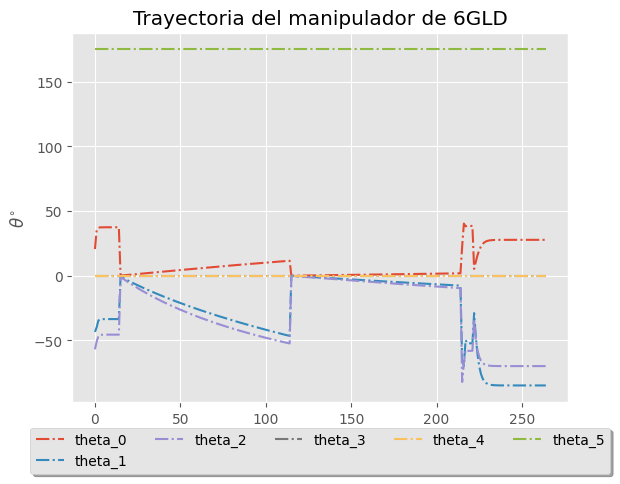

In [21]:
for key_, angles in values_angles.items():
    plt.plot(angles, label=key_, linestyle="-.", linewidth=1.5)
plt.xlabel("Iteraciones") 
plt.ylabel(r"$\theta^{\circ}$") 
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Trayectoria del manipulador de 6GLD")
plt.show()

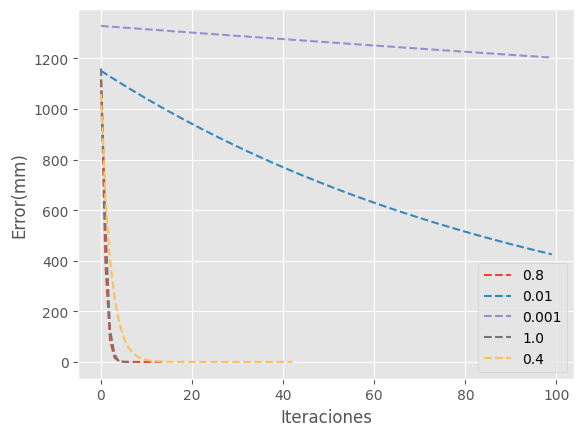

In [22]:

for key_, angles in error_.items():
    plt.plot(angles, label=key_, linestyle="--", linewidth=1.5)
plt.xlabel("Iteraciones") 
plt.ylabel("Error(mm)")
plt.legend()
plt.show()

*****
<center><span style="color:black">Despues de haber calculado la cinematica inversa del punto incial de los cordones de soldadura, aplicamos cinematica diferencial debido a que los cordones de soldadura son lineales y el metodo de Newton nos da una solucion articular, por lo tanto debemos utlizar otro metodo.</span></center><br><br>

****


In [23]:
# Any interaction with RoboDK must be done through RDK:
RDK = Robolink()

In [24]:
# >> Robots
#
#
robot_1 = RDK.Item('Motoman AR2010-1', ITEM_TYPE_ROBOT)
robot_2 = RDK.Item('Motoman AR2010-2', ITEM_TYPE_ROBOT)

In [34]:
R1_home = RDK.Item('HomeR1')
R2_home = RDK.Item('HomeR2')

In [35]:
# >> Colocamos en Home a los robots
robot_1.MoveJ(R1_home)
robot_2.MoveJ(R2_home)

In [27]:
# >> Traemos la posicion actual de los robots
#
#
solution_R1 = robot_1.SolveIK_All(robot_1.Pose(), robot_1.PoseTool(), robot_1.PoseFrame())
solution_R2 = robot_2.SolveIK_All(robot_1.Pose(), robot_1.PoseTool(), robot_1.PoseFrame())

**<span style="color:blue">Nata:</span>**<br>
- **<span style="color:gray">Posiciones inciales de los cordones de sodadura en ambas direcciones.</span>**<br>

***

In [28]:
robot_1_angles = {
"w1+": [[-40.42, -35.31, -40.19, -54.87, -83.67, -148.66]],
"w1-": [[-39.29, -33.66, -39.18, -54.96, -82.38, -148.78]],
"w2+": [[-37.92, -31.53, -37.85, -55.08, -80.81, -148.91]],
"w2-": [[-38.98, -33.19, -38.90, -54.98, -82.03, -148.81]],
"w3+": [[7.65, -52.13, -48.88, 47.02, -62.76, 176.51]],
"w3-": [[7.36, -49.82, -47.85, 47.39, -61.68, 175.69]],
"w4+": [[7.01, -46.90, -46.47, 47.89, -60.38, 174.65]],
"w4-": [[7.318278769799425, -48.37799553686668, -47.00390743485115, 47.15833494537402, -62.305195763753176, -183.81986757628903]],
"w5+": [[-27.73, -45.30, -45.68, -53.46, -75.99, -159.89]],
"w5-": [[-26.79, -43.29, -44.65, -53.54, -74.66, -159.64]],
"w6+": [[-25.68, -40.72, -43.28, -53.67, -73.05, -159.33]],
"w6-": [[-26.54, -42.73, -44.36, -53.56, -74.30, -159.57]],
"w7+": [[24.72, -46.91, -46.47, 52.80, -74.08, 162.43]],
"w7-": [[23.86, -44.83, -45.44, 52.90, -72.76, 162.10]],
"w8+": [[22.84, -42.19, -44.07, 53.05, -71.18, 161.68]],
"w8-": [[23.63, -44.25, -45.15, 52.93, -72.41, 162.01]],
"w9+": [[-11.29, -51.51, -48.61, -48.53, -65.21, -173.52]],
"w9-": [[-10.86, -49.23, -47.58, -48.82, -64.07, -172.80]],
"w10+": [[-10.35, -46.34, -46.20, -49.22, -62.70, -171.90]],
"w10-": [[-10.74, -48.60, -47.28, -48.91, -63.76, -172.60]],
"w11+": [[38.18, -37.51, -41.48, 54.79, -82.37, 150.70]],
"w11-": [[37.07, -35.79, -40.47, 54.87, -81.06, 150.75]],
"w12+": [[35.73557432439154, -33.56838341594566, -39.1295007675843, 54.981710320103375, -79.46587458304006, 150.8049917341383]],
"w12-": [[36.77370444318182, -35.3020340414703, -40.18320002030701, 54.89376661124852, -80.70269107159461, 150.76707040960642]],
"w13+": [[7.203319840725981, -52.18487434898669, -48.90972859633892, -39.26713824775963, -52.588205817262484, 170.65926418053897]],
"w13-": [[6.924085512009022, -49.8755253938656, -47.87364580337942, -40.07745267618955, -51.78619994783462, 171.9599324859854]],
"w14+": [[6.596629048459238, -46.94896221173555, -46.49092847378138, -41.088157189741594, -50.82661172747251, 173.5652929651672]],
"w14-": [[6.849719412945364, -49.23242655161884, -47.57652556026675, -40.30116817229475, -51.569865610958566, 172.31688855918333]],
"w15+": [[48.044358941563054, -25.88281434807908, -34.07954628010819, 54.51965083036409, -87.9493924740452, 141.5604125255024]],
"w15-": [[46.904520038459445, -24.498458008854644, -33.10242674259315, 54.671424028777125, -86.79436978970863, 141.88210086077737]],
"w16+": [[45.50502458761369, -22.698495677934527, -31.800343437172543, 54.86005424757053, -85.37764925072719, 142.27413945559957]],
"w16-": [[46.59275504485857, -24.107290507985613, -32.822510181442674, 54.7132309562698, -86.4785517881623, 141.9696000060277]],
"w17+": [[24.340578390300053, -47.0965822309523, -46.56256282482264, -26.42313013884775, -40.896368446573604, 152.92195140376495]],
"w17-": [[23.4926009320799, -45.01347438815088, -45.532936653251916, -27.86341195523826, -40.345727830249196, 154.81923811320343]],
"w18+": [[22.485418907995385, -42.357830763193874, -44.16104624131854, -29.629561706609167, -39.704403317205234, 157.15211980158375]],
"w18-": [[23.265068559551786, -44.431393283747184, -45.23796029397152, -28.2571599372057, -40.199394636419434, 155.3387543243551]],
"w19+": [[55.19092225999816, -13.350089682483103, -24.44778128959023, 53.32626000212471, -91.94247200735877, 135.0709067831849]],
"w19-": [[54.111136666484015, -12.228702724250963, -23.497864297953463, 53.54831598241196, -90.98950346287586, 135.56435767695785]],
"w20+": [[52.77077798300102, -10.757490874088782, -22.229143528876424, 53.81687707450765, -89.81077611477468, 136.1794697937516]],
"w20-": [[53.81395151585773, -11.910241373190395, -23.22540112199613, 53.60854692662966, -90.72768653054776, 135.70038913669657]],
"w21+": [[37.89548279430138, -37.77355901073451, -41.63267881579504, -11.318617080478779, -32.26866274206209, 133.73713976827148]],
"w21-": [[36.79199930007444, -36.04197126575376, -40.62360519192661, -13.201635732669088, -31.79625222076127, 136.0540309344387]],
"w22+": [[35.457958627478874, -33.813370814523914, -39.28027092652071, -15.54132986455644, -31.268426247292812, 138.93592382220794]],
"w22-": [[36.4928504879566, -35.555493331309734, -40.33468183966629, -13.720435841036599, -31.67352836532596, 136.69273049548195]],
"w23+": [[60.4556628050409, -0.42281115208164016, -12.589061590432438, 52.008812831266056, -95.39649857326489, 131.08712999628264]],
"w23-": [[59.464054959975314, 0.5207194368881122, -11.644973945818611, 52.27002899753825, -94.63153557768294, 131.684775342997]],
"w24+": [[58.22374188411708, 1.7684680427926052, -10.380002803428638, 52.58595918222266, -93.68101305681844, 132.43973156199874]],
"w24-": [[59.189961284062335, 0.7898590958596885, -11.373707329935534, 52.34088892079802, -94.42082053973915, 131.85080793398794]],
"w25+": [[47.838433514021396, -26.182971269587433, -34.2886388844528, 4.534881689493856, -27.390876027716697, 114.32726037427385]],
"w25-": [[46.69791344018905, -24.791094506068127, -33.31073218627401, 2.5529979125209525, -26.90785223663731, 116.73976567128003]],
"w26+": [[45.29802927069969, -22.981780048202253, -32.00765525593981, 0.031462852724651734, -26.370389578358992, 119.79944751524727]],
"w26-": [[46.386019103895556, -24.39785403044461, -33.03059656248633, 1.9995148095162807, -26.78258568433535, 117.41222988584474]],
"w27+": [[64.43341970023572, 13.034359860563143, 1.8868962226771389, 50.99792357628162, -99.07963246080973, 129.44638253839832]],
"w27-": [[63.53144385778967, 13.882318781545564, 2.871173436386111, 51.273412231944064, -98.47594115960679, 130.11578149191277]],
"w28+": [[62.397241109906794, 15.012527926839146, 4.196147898116251, 51.608653210206064, -97.72645633283351, 130.97078706115883]],
"w28-": [[63.2813804000239, 14.125248157539742, 3.1547077351815145, 51.348402914925984, -98.30971616273867, 130.30292576292365]],

}

In [29]:
robot_2_angles = {
"w1+": [[-66.40643116233093, 21.639124312607315, 12.26111510694022, -50.673038744673434, -101.70234895273617, -129.59441580465557]],
"w1-": [[-65.55433579641068, 22.474015737784885, 13.312601493359676, -50.95186504685593, -101.1873783571376, -130.30785003799392]],
"w2+": [[-65.31778002343272, 22.713973755348224, 13.616253877634554, -51.02801167551658, -101.04598730679466, -130.50811575369065]],
"w2-": [[-64.4802580187878, 23.593386983754005, 14.734580155048421, -51.29316998445804, -100.55145084590139, -131.22571714306252]],
"w3+": [[-52.47493289010315, -18.7808749928536, -28.84088750156748, -13.383447616941359, -26.16947582536088, -103.60212409264011]],
"w3-": [[-51.36225770813589, -17.559287280682394, -27.882413344759016, -11.496642440503946, -25.67654522695885, -105.91884175777619]],
"w4+": [[-51.05674383267164, -17.21306702573384, -27.607649248347872, -10.965691767544556, -25.54792129247331, -106.56856828566012]],
"w4-": [[-49.986816315825386, -15.962376704379386, -26.603570187888856, -9.06335138430952, -25.122060730237106, -108.88936593980605]],
"w5+": [[-63.005731083795624, 7.519664924039767, -4.307203354508764, -51.33318963422891, -97.5637715269644, -129.79821023930006]],
"w5-": [[-62.06790193138954, 8.394547851408445, -3.3486472361268103, -51.60560070796995, -96.89771011548464, -130.44065944573134]],
"w6+": [[-61.808173481209195, 8.644751043958127, -3.0728354520153704, -51.679636567517754, -96.71418786794683, -130.61981502421125]],
"w6-": [[-60.890834353654306, 9.556924939555058, -2.060985779154836, -51.93616391072978, -96.06973175243031, -131.25758473710843]],
"w7+": [[-44.29037884307086, -31.046823921775385, -37.5415327524743, 1.6700289588580632, -28.91589564165778, -121.87325760226237]],
"w7-": [[-43.14559091151912, -29.526803392983837, -36.5520978354385, 3.6567305245948702, -28.438629208609168, -124.29122376405684]],
"w8+": [[-42.83352699695296, -29.098286662424826, -36.26873524583488, 4.208535347449747, -28.315053680209676, -124.9622123950473]],
"w8-": [[-41.74828133436348, -27.558498869719934, -35.2343229827628, 6.160192137108394, -27.90892231610737, -127.33378286553476]],
"w9+": [[-58.57383246165606, -5.676219368106849, -17.649427670214678, -52.50813527621853, -94.05937741587645, -132.37051185946743]],
"w9-": [[-57.54492936534163, -4.6725580207173945, -16.708308623861544, -52.75784064187378, -93.22156151947715, -132.93274010313846]],
"w10+": [[-57.260959492955344, -4.386745490453518, -16.438092509440516, -52.82553218594151, -92.9909425044409, -133.0884882609908]],
"w10-": [[-56.261436445983215, -3.349293913064681, -15.448997897099018, -53.059501777034555, -92.18179591121132, -133.63945589605902]],
"w11+": [[-32.98426463387283, -41.952644007268475, -43.945810246790586, 17.483249971827355, -35.30094757140538, -141.44986922163517]],
"w11-": [[-31.946294652191664, -40.07585089421927, -42.92814857237391, 19.22785440026261, -34.81205241863836, -143.63460746027187]],
"w12+": [[-31.666055907619125, -39.549752520384295, -42.63672254130117, 19.706469584153037, -34.684063395490014, -144.2347680566649]],
"w12-": [[-30.70029972132782, -37.6698526628621, -41.57308936109967, 21.37975439175604, -34.25792658025151, -146.3357654315464]],
"w13+": [[-52.6448047212415, -18.47117460261902, -28.599509452005627, -53.84366032931167, -90.5037019769996, -137.33692138341564]],
"w13-": [[-51.533782504908594, -17.25587089409639, -27.641693587760624, -54.04139483802156, -89.46831881811949, -137.7722550821422]],
"w14+": [[-51.22867741545965, -16.911389556960888, -27.367109425595164, -54.09517603158229, -89.1843277730898, -137.89175527337807]],
"w14-": [[-50.160027347257994, -15.666828169891817, -26.363654209310464, -54.28172548516336, -88.19135616498066, -138.311008813328]],
"w15+": [[-17.874670562381432, -49.84076743034685, -47.85768336886287, 31.852677114087932, -45.315805750990556, -160.1541668618285]],
"w15-": [[-17.215934866639095, -47.64235796328334, -46.825655990115315, 33.0504041938776, -44.684883345153544, -161.82517370517598]],
"w16+": [[-17.03984489497506, -47.02910671401967, -46.52984459349023, 33.378137289692525, -44.51575424129665, -162.28261694498656]],
"w16-": [[-16.43853734967222, -44.84808640579151, -45.44944909151076, 34.521582868243506, -43.93853369694728, -163.87899203901608]],
"w17+": [[-44.52494657540233, -30.756634564503017, -37.35452203327324, -54.798049855354435, -86.02634473903063, -144.88755271811308]],
"w17-": [[-43.37977750056839, -29.24485952151149, -36.3658786181094, -54.91663128767761, -84.79550181819184, -145.11497531560448]],
"w18+": [[-43.06754475159133, -28.818608635338894, -36.08273849959667, -54.9500027383436, -84.45973409342285, -145.17608543179645]],
"w18-": [[-41.98149568977296, -27.28675368759959, -35.04912067060267, -55.06956081177742, -83.2919245870581, -145.3865497752372]],
"w19+": [[0.22981629347746235, -52.73476212345608, -49.14936797723897, 43.45244494525954, -57.73013171593368, 182.80572939449758]],
"w19-": [[0.2208044176743132, -50.4029896345759, -48.11453546935644, 44.02439310328646, -56.78683455194512, 181.74743397201243]],
"w20+": [[0.21840636993292567, -49.7538458287006, -47.81771695591419, 44.184492475343525, -56.532171040752225, 181.45597981099354]],
"w20-": [[0.2102512432892386, -47.449591666245915, -46.73304676406673, 44.75464699802085, -55.65610999597852, 180.43359625489106]],
"w21+": [[-33.30648882703218, -41.71261785415932, -43.81756240609987, -54.35969908395608, -79.48658597094631, -155.09825732440243]],
"w21-": [[-32.26316699693649, -39.84472091090702, -42.800450766769096, -54.42252919475147, -78.14381816808083, -155.0118258365775]],
"w22+": [[-31.981411140947245, -39.32104455890698, -42.509185677435624, -54.443045285653525, -77.77977412075985, -154.98585398831938]],
"w22-": [[-31.010194518257357, -37.44954951876959, -41.446147754733175, -54.525557597384065, -76.52115017149862, -154.8884855100976]],
"w23+": [[18.290022914687594, -49.69950466328218, -47.79269607441514, 51.006529714622395, -69.9190230405382, 167.8137197834387]],
"w23-": [[17.617977891569613, -47.507381670046776, -46.76084638149147, 51.172730715603, -68.66744349610131, 167.29970030189656]],
"w24+": [[17.438292724142016, -46.89582604596263, -46.46509408070786, 51.223484123512364, -68.32952723326781, 167.15619296669993]],
"w24-": [[16.82459225684087, -44.72063912448251, -45.38493820788853, 51.4175727781759, -67.16607743291476, 166.6469910446796]],
"w25+": [[-18.290022914687587, -49.69950466328222, -47.7926960744152, -51.006529714622395, -69.9190230405382, -167.8137197834387]],
"w25-": [[-17.617977891569605, -47.507381670046776, -46.76084638149147, -51.172730715603, -68.6674434961013, -167.29970030189665]],
"w26+": [[-17.438292724142016, -46.89582604596263, -46.46509408070786, -51.22348412351236, -68.32952723326781, -167.1561929667]],
"w26-": [[-16.824592256840862, -44.720639124482545, -45.38493820788857, -51.41757277817591, -67.16607743291476, -166.6469910446796]],
"w27+": [[33.306488827032176, -41.71261785415934, -43.8175624060999, 54.35969908395608, -79.48658597094628, 155.09825732440243]],
"w27-": [[32.263166996936484, -39.844720910906986, -42.80045076676906, 54.42252919475148, -78.14381816808083, 155.01182583657754]],
"w28+": [[31.98141114094723, -39.32104455890698, -42.509185677435624, 54.44304528565352, -77.77977412075984, 154.98585398831938]],
"w28-": [[31.01019451825735, -37.44954951876963, -41.446147754733225, 54.525557597384065, -76.52115017149859, 154.8884855100976]],

}

*****

##### **<center><span style="color:blue">Cinemática Diferencial</span></center>**

*****

- **<span style="color:gray">Leer el punto inicial y final de los cordones de soldadura de ambos robots.</span><br>**

In [30]:
robot1_path = "./Welds/Robot-1"
robot2_path = "./Welds/Robot-2"

In [31]:
split_coodinate = lambda x: [float(x) for x in str(x).replace("\n", "").split(",")]

In [32]:
# >> Cordones de soldadura para el Robot-1
#
#
R1_welds = {}
for index, weld in enumerate(Path(robot1_path).iterdir()):
    file_name, extension = os.path.splitext(weld.name)
    file_name = file_name.replace("Weld", "")
    trajectories = files.readFile(filepath=weld)
    trajectories = list(map(split_coodinate, trajectories))
    R1_welds[f"w{file_name}+"] = trajectories
    R1_welds[f"w{file_name}-"] = list(reversed(trajectories))
# >> Cordones de soldadura para el Robot-2
#
#
R2_welds = {}
for index, weld in enumerate(Path(robot2_path).iterdir()):
    file_name, extension = os.path.splitext(weld.name)
    file_name = file_name.replace("Weld", "")
    trajectories = files.readFile(filepath=weld)
    trajectories = list(map(split_coodinate, trajectories))
    R2_welds[f"w{file_name}+"] = trajectories
    R2_welds[f"w{file_name}-"] = list(reversed(trajectories))

- **<span style="color:gray">Obtenemos la cinematica diferencial de los Robots de soldadura.</span><br>**

****

In [33]:
# >> Clase
#
#
class CustomThreadR1(Thread):
    def __init__(self, robot_1_output, welds, angles, write_file, robotDK, jacobian):
        super(CustomThreadR1, self).__init__()
        self.robot_1_output = robot_1_output
        self.welds = welds
        self.angles = angles
        self.write_file = write_file
        self.robotDK = robotDK
        self.jacobian = jacobian
    # Version 1.3
    def run(self):
        for index, (weld_name, trajectory )in enumerate(self.welds.items()):
            # >> Creamos archivo
            file_path = os.path.join(self.robot_1_output, f"{weld_name}.txt")
            self.write_file(file_path=file_path, data=[], type_mode="w")
            # >> Posicion inicial y final del los cordones de soldadura
            x_initial = trajectory[0][0]
            x_end = trajectory[1][0]
            # >> Desplazamiento en el eje X
            displacement = np.array([1, 0, 0])
            #
            if x_initial - x_end < 0:
                displacement = np.array([1, 0, 0])
            else:
                displacement = np.array([-1, 0, 0])
            for i in range(int(abs(x_initial - x_end))):
                # print(i)
                if i == 0:
                    initial_position_ = self.angles[weld_name][0]
                    self.robotDK.MoveJ(initial_position_)
                    self.write_file(file_path=file_path, data=[','.join(map(str, initial_position_))], type_mode="a")
                # >> Punto final [x, y, z]
                #
                # print(trajectory)
                end_point = np.array(trajectory)
                # >> Posicion Actual del Robot
                #
                #
                solution_R1 = self.robotDK.SolveIK_All(self.robotDK.Pose(), self.robotDK.PoseTool(), self.robotDK.PoseFrame())
                R1_current_position = np.ravel(solution_R1[:6,0])
                # >> Transformamos los angulos a radianes
                #
                #
                q4_actual, q5_actual, q6_actual = R1_current_position[3:] * (np.pi/180)
                theta_init = R1_current_position[:3] * (np.pi/180)
                q1_actual, q2_actual, q3_actual = theta_init
                # >> Cinematica diferencial
                #
                #
                J0 = self.jacobian.evalf(subs= {q1: q1_actual, q2: q2_actual, q3: q3_actual, q4: q4_actual, q5: q5_actual, q6: q6_actual})
                dq = np.array(J0.inv().tolist()).astype(np.float64) @ displacement
                q = theta_init + dq
                # >> Solucion de los angulos de las articulaciones
                #
                #
                solution = np.concatenate((q * (180 / np.pi), R1_current_position[3:]), axis=0).tolist()
                # >> Simulamos los movimientos
                self.robotDK.MoveJ(solution)
                # >> Guardamos los angulos de las articulaciones en la carpeta output y al robot que corresponde
                #
                #
                self.write_file(file_path=file_path, data=[','.join(map(str, solution))], type_mode="a")
 
 
if __name__ =="__main__":
    # >> Creamos el thread
    #
    # >> Thread para Robot-1
    #
    #
    R1_parameters = {
        "robot_1_output": robot_1_output, "welds": R1_welds,
        "angles": robot_1_angles, "write_file": files.write_file,
        "robotDK": robot_1, "jacobian": jacobian}
    R1_thread = CustomThreadR1(**R1_parameters)
    # >> Thread para Robot-2
    #
    #
    R2_parameters = {
        "robot_1_output": robot_2_output, "welds": R2_welds,
        "angles": robot_2_angles, "write_file": files.write_file,
        "robotDK": robot_2, "jacobian": jacobian}
    R2_thread = CustomThreadR1(**R2_parameters)
    # >> Iniciamo los threads del Robot-1 y Robot-2
    #
    #
    R2_thread.start()
    R1_thread.start()
    # >> Esperamos a que terminen los procesos en paralelo (thread)
    #
    #
    R2_thread.join()
    R1_thread.join()

*****

##### **<center><span style="color:blue">Simulación y detección de colisión</span></center>**

*****

In [36]:
"""
# >> Leer los angulos de las trayectorias de los cordones de soldadura guardados en la carpeta Output
"""
# >> Cordones de soldadura para el Robot-1
#
#
R1_angles = {}
for index, weld in enumerate(Path(robot_1_output).iterdir()):
    file_name, extension = os.path.splitext(weld.name)
    file_name = file_name.replace("Weld", "")
    trj_angles = files.readFile(filepath=weld)
    trj_angles = list(map(split_coodinate, trj_angles))
    R1_angles[file_name] = trj_angles
# >> Cordones de soldadura para el Robot-2
#
#
R2_angles = {}
for index, weld in enumerate(Path(robot_2_output).iterdir()):
    file_name, extension = os.path.splitext(weld.name)
    file_name = file_name.replace("Weld", "")
    trj_angles = files.readFile(filepath=weld)
    trj_angles = list(map(split_coodinate, trj_angles))
    R2_angles[file_name] = trj_angles

- **<span style="color:gray">Generar combinaciones con el algoritmo TSP.</span><br>**

****

In [38]:
# >> Generar ruta para escribir los resultados
#
#
tsp_output_path = "./Output/Sequences"
if not os.path.isdir(tsp_output_path):
    os.mkdir(tsp_output_path)

In [39]:
# >> Nombre de los cordones de soldadura
#
#
welds_name = list(R2_welds.keys())
# >> Obtener la distancia euclideana entre dos puntos en el espacio 3D
#
#
get_euclidean_distance = lambda a, b: np.linalg.norm(a - b)

In [ ]:
# >> Parametros
"""
Los parametros que requiere el algoritmo son:
 - Nombre de los cordones ['w1+', 'w1-', 'w2+', ..., 'wn+', 'wn-']
 - Numero decombianciones que se desea encontrar
 - las coordenadas del punto incial y final de los coordones
 - Numero de robots
"""
#
#
number_sequences = 200
count = 0
sequences = {}
for i in range(number_sequences):
    print(i)
    temp_welds = trajectoiries_name.copy()
    sequences[f"c{i + 1}"] = {"R1": [], "R2": []}
    # >> Seleccionar de forma aleatoria los cordones de sodadura
    # >> Seleccionar el cordon para el Robot-1
    rbt_1 = np.random.choice(temp_welds, 1)
    
    # >> Elimamos el cordon para que no vuelva a ser selccionado
    #
    #
    R1_weld_name = rbt_1[0].replace("+", "").replace("-", "")
    temp_welds.remove(R1_weld_name + "-")
    temp_welds.remove(R1_weld_name + "+")
    # >> Consulta las coordenadas del cordon seleccionado por el robot 1

    __coodinate_R1 = R2_welds[rbt_1[0]][1]
    #
    # >> Seleccionamos el cordon para el robot-2
    #
    # >> Distancia para robot 1
    distance_R1 = {}
    for weld in temp_welds:
        distance_R1[weld] = get_euclidean_distance(np.array(__coodinate_R1), np.array(R2_welds[weld][0]))
    
    # >> Seleccionamos el cordon que tiene mayor diatancia para evitar colision
    #
    #
    rbt_2 = max(distance_R1, key=distance_R1.get)
    # >> Elimamos el cordon para que no vuelva a ser selccionado
    #
    #
    R2_weld_name = rbt_2.replace("+", "").replace("-", "")
    temp_welds.remove(R2_weld_name + "-")
    temp_welds.remove(R2_weld_name + "+")
    # >> Agregamos a la variable los cordones seleccionados
    #
    #
    sequences[f"c{i + 1}"]["R1"].append(rbt_1[0])
    sequences[f"c{i + 1}"]["R2"].append(rbt_2)
    #
    #
    # >> Consulta las coordenadas de los cordon seleccionado por el robot  2
    __coodinate_R2 = R2_welds[rbt_2][1]
    while temp_welds:
        # >> Obtenemos las distancias euclideanas del punto final de los cordones seleccionados con los que aun estan disponibles
        # >> Distancia para robot 1
        distance_R1 = {}
        for weld in temp_welds:
            distance_R1[weld] = get_euclidean_distance(np.array(__coodinate_R1), np.array(R2_welds[weld][0]))
        # >> Seleccionamos el cordon que tiene menor diatancia
        #
        #
        weld_min_R1 = min(distance_R1, key=distance_R1.get)
        # >> Elimamos el cordon para que no vuelva a ser selccionado
        #
        #
        R1_weld_name = weld_min_R1.replace("+", "").replace("-", "")
        temp_welds.remove(R1_weld_name + "-")
        temp_welds.remove(R1_weld_name + "+")

        # >> Distancia para robot 2
        distance_R2 = {}
        for weld in temp_welds:
            distance_R2[weld] = get_euclidean_distance(np.array(__coodinate_R2), np.array(R2_welds[weld][0]))
        # >> Seleccionamos el cordon que tiene menor diatancia
        #
        #
        weld_min_R2 = min(distance_R2, key=distance_R2.get)
        # >> Elimamos el cordon para que no vuelva a ser selccionado
        #
        #
        R2_weld_name = weld_min_R2.replace("+", "").replace("-", "")
        temp_welds.remove(R2_weld_name + "-")
        temp_welds.remove(R2_weld_name + "+")


        # >> Actualizamos la coordenadas de la posicion de los cordones seleccionados
        __coodinate_R1 = R2_welds[weld_min_R1][1]
        __coodinate_R2 = R2_welds[weld_min_R2][1]
        # >> Agregamos a la variable los cordones seleccionados
        #
        #
        sequences[f"c{i + 1}"]["R1"].append(weld_min_R1)
        sequences[f"c{i + 1}"]["R2"].append(weld_min_R2)

# >> Guardamos los resultados en el archiv ./output/Sequences/seqeunces.txt
file_sequence_path = os.path.join(tsp_output_path, "sequences.txt")
files.write_file_string(file_path=file_sequence_path, data_string=json.dumps(sequences, indent=4), type_mode="w")


In [76]:
"""
# >> Leemos las secuencias generadas por el Algoritmo TSP

Ejemplo de secuencias generadas:

# combinations = {
# "c21": {
# "R1": ["w1+", "w2+", "w3+", "w4+", "w5+", "w6+", "w7+", "w8+", "w8+", "w9+", "w10+", "w11+", "w12+", "w13+", "w14+"],
# "R2": ["w15+", "w16+", "w17+", "w18+", "w19+", "w20+", "w21+", "w22+", "w23+", "w24+", "w25+", "w26+", "w27+", "w28+"]
# },
# "c22": {
# "R1": ["w15+", "w2+", "w3+", "w4+", "w5+", "w6+", "w7+", "w8+", "w8+", "w9+", "w10+", "w11+", "w12+", "w13+", "w14+"],
# "R2": ["w1+", "w16+", "w17+", "w18+", "w19+", "w20+", "w21+", "w22+", "w23+", "w24+", "w25+", "w26+", "w27+", "w28+"]
# }

# }
"""
file_sequence_path = os.path.join(tsp_output_path, "sequences.txt")
combinations = json.loads(files.readFileString(file_sequence_path))


- **<span style="color:gray">Realizar las simulaciones para detectar colisión.</span><br>**

****

In [77]:
# >> Simulacion
#
#
class SimulationThread(Thread):
    def __init__(self, robotDK, sequence, event, angles, robot2):
        super(SimulationThread, self).__init__()
        self.robotDK = robotDK
        self.sequence = sequence
        self.event = event
        self.angles = angles
        self.robot2 = robot2
        self.get_complete = False
    # Version 1.3
    def run(self):
        for index, sequence in enumerate(self.sequence):
            # >> Simulamos los movimientos
            # print("Angle:", self.angles[sequence])
            for trajectori in self.angles[sequence]:
                self.robotDK.MoveJ(trajectori)
                # Revisar si no existe colision
                if self.event.is_set():
                    return -1
                collision = self.robotDK.Collision(self.robot2)
                # print(f"Collision: {self.robotDK.Name()}", collision)
                if collision == 1:
                    self.get_complete = False
                    return -1
        self.get_complete = True
# >> Detectar Colision
#
#
class CustomThreadCollision(Thread):
    def __init__(self, robot1, robot2, event, R1_event, R2_event):
        super(CustomThreadCollision, self).__init__()
        self.robot1 = robot1
        self.robot2 = robot2
        self.event = event
        self.R1_event = R1_event
        self.R2_event = R2_event
        self.state_collision = False
    # Version 1.3
    def run(self):
        while True:
            # Revisar si no existe colision
            collisionR1 = self.robot1.Collision(self.robot2)
            collisionR2 = self.robot2.Collision(self.robot1)
            print("Collision:", collisionR2, collisionR2)
            if collisionR1 == 1 or collisionR2 == 1:
                print("Stop threads...")
                self.R1_event
                self.R2_event
                self.get_complete = True
            if self.event.is_set():
                return -1
if __name__ =="__main__":
    # >> Definimos la ruta para guardar los resultados
    simulation_path = "./Output/Simulation"
    if not os.path.isdir(simulation_path):
        os.mkdir(simulation_path)
    fail_path = os.path.join(simulation_path, "Fail.txt")
    successful_path = os.path.join(simulation_path, "Seccesful.txt")
    files.write_file_string(file_path=fail_path, data_string="", type_mode="w")
    files.write_file_string(file_path=successful_path, data_string="", type_mode="w")
    
    # >> Colocamos en Home a los robots
    #
    #
    robot_1.MoveJ(R1_home)
    robot_2.MoveJ(R2_home)
    # create the event
    R1_event = Event()
    R2_event = Event()
    #
    #
    sequence_complete = []
    time.sleep(5)
    for sequence_name, sequence in combinations.items():
        if sequence_name in ["c10", "c32"]:
            # >> Creamos el thread
            #
            # >> Thread para Robot-1
            #
            #  robotDK, sequence, event, angles
            try:
                RDK.setCollisionActive(check_state=1)
                R1_parameters = {
                    "robotDK": robot_1, "sequence": sequence.get("R1"),
                    "angles": R1_angles, "event": R1_event, "robot2": robot_2}
                R1_thread = SimulationThread(**R1_parameters)
                # >> Thread para Robot-2
                #
                #
                R2_parameters = {
                    "robotDK": robot_2, "sequence": sequence.get("R2"),
                    "angles": R2_angles, "event": R2_event, "robot2": robot_1}
                R2_thread = SimulationThread(**R2_parameters)
                # >> Iniciamo los threads del Robot-1 y Robot-2
                #
                #
                R2_thread.start()
                R1_thread.start()
                # >> Esperamos a que terminen los hilos
                #
                #
                R2_thread.join()
                R1_thread.join()
                # >> Colocamos en Home a los robots
                #
                #
                robot_1.MoveJ(R1_home)
                robot_2.MoveJ(R2_home)
                if R1_thread.get_complete and R2_thread.get_complete:
                    print(prGreen("Secuencia sin colision:"), prBlack(sequence_name))
                    sequence_complete.append(sequence_name)
                    files.write_file(file_path=successful_path, data=[sequence_name], type_mode="a")
                else:
                    files.write_file(file_path=fail_path, data=[sequence_name], type_mode="a")
                    print(prRed("Secuencia con colision:"), prBlack(sequence_name))
                time.sleep(4)
            except:
                time.sleep(2)
                RDK.setCollisionActive(check_state=0)
                files.write_file(file_path=fail_path, data=[sequence_name], type_mode="a")
                print(prRed("Secuencia con colision:"), prBlack(sequence_name))
                robot_1.MoveJ(R1_home)
                robot_2.MoveJ(R2_home)
                time.sleep(4)

Exception in thread Thread-130:
Traceback (most recent call last):
  File "c:\RoboDK\Python37\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\Users\WIA5056\AppData\Local\Temp\ipykernel_11624\2361708057.py", line 19, in run
    self.robotDK.MoveJ(trajectori)
  File "c:\RoboDK\Python37\lib\site-packages\robodk\robolink.py", line 5442, in MoveJ
    self.link._moveX(target, self, MOVE_TYPE_JOINT, blocking)
  File "c:\RoboDK\Python37\lib\site-packages\robodk\robolink.py", line 1014, in _moveX
    self._check_status()  #will wait here
  File "c:\RoboDK\Python37\lib\site-packages\robodk\robolink.py", line 767, in _check_status
    raise StoppedError(self.LAST_STATUS_MESSAGE)
robodk.robolink.StoppedError: Collision detected



 Secuencia con colision:  c10
 Secuencia sin colision:  c32


*****

##### **<center><span style="color:blue">Tiempo de ciclo</span></center>**

*****

In [43]:
# >> Tiempo de ciclo del Robot-1
#
#
weld_time_R1 = {"w1+": 0.16, "w1-": 0.17, "w2+": 0.15, "w2-": 0.15, "w3+": 0.19, "w3-": 0.18, "w4+": 0.17, "w4-": 0.17,
                "w5+": 0.18, "w5-": 0.18, "w6+": 0.14, "w6-": 0.14, "w7+": 0.18, "w7-": 0.18, "w8+": 0.22, "w8-": 0.22,
                "w9+": 0.17, "w9-": 0.17, "w10+": 0.18, "w10-": 0.20, "w11+": 0.15, "w11-": 0.15, "w12+": 0.19, "w12-": 0.19,
                "w13+": 0.20, "w13-": 0.20,
                "w14+": 0.18, "w14-": 0.18, "w15+": 0.15, "w15-": 0.15, "w16+": 0.15, "w16-": 0.15, "w17+": 0.18, "w17-": 0.17,
                "w18+": 0.18, "w18-": 0.17, "w19+": 0.14, "w19-": 0.14, "w20+": 0.20, "w20-": 0.20, "w21+": 0.21, "w21-": 0.21,
                "w22+": 0.22, "w22-": 0.22, "w23+": 0.23, "w23-": 0.23, "w24+": 0.22, "w24-": 0.22, "w25+": 0.21, "w25-": 0.21,
                "w26+": 0.23, "w26-": 0.23, "w27+": 0.20, "w27-": 0.20, "w28+": 0.19, "w28-": 0.19}
weld_time_R2 = {"w1+": 0.14, "w1-": 0.14, "w2+": 0.16, "w2-": 0.16, "w3+": 0.19, "w3-": 0.18, "w4+": 0.17, "w4-": 0.17,
                "w5+": 0.18, "w5-": 0.17, "w6+": 0.15, "w6-": 0.15, "w7+": 0.22, "w7-": 0.22, "w8+": 0.21, "w8-": 0.21,
                "w9+": 0.17, "w9-": 0.17, "w10+": 0.22, "w10-": 0.22, "w11+": 0.14, "w11-": 0.14, "w12+": 0.23, "w12-": 0.23,
                "w13+": 0.15, "w13-": 0.16,
                "w14+": 0.18, "w14-": 0.18, "w15+": 0.21, "w15-": 0.21, "w16+": 0.16, "w16-": 0.16, "w17+": 0.14, "w17-": 0.14,
                "w18+": 0.22, "w18-": 0.24, "w19+": 0.16, "w19-": 0.15, "w20+": 0.17, "w20-": 0.17, "w21+": 0.18, "w21-": 0.17,
                "w22+": 0.23, "w22-": 0.23, "w23+": 0.24, "w23-": 0.24, "w24+": 0.18, "w24-": 0.17, "w25+": 0.20, "w25-": 0.20,
                "w26+": 0.18, "w26-": 0.17, "w27+": 0.14, "w27-": 0.14, "w28+": 0.15, "w28-": 0.17}

In [89]:
successful_sequences = files.readFile("./Output/Simulation/Seccesful.txt")
fail_sequences = files.readFile("./Output/Simulation/Fail.txt")

In [90]:
successful_sequences = list(map(lambda x: x.replace("\n", ""), successful_sequences))
fail_sequences = list(map(lambda x: x.replace("\n", ""), fail_sequences))

In [119]:
# Creating our own dataframe
data = {"Sequences": ["Successful", "Collision"],
        "Cantidad": [len(successful_sequences), len(fail_sequences)]}
 
# Now convert this dictionary type data into a pandas dataframe
# specifying what are the column names
df = pd.DataFrame(data, columns=['Sequences', 'Cantidad'])

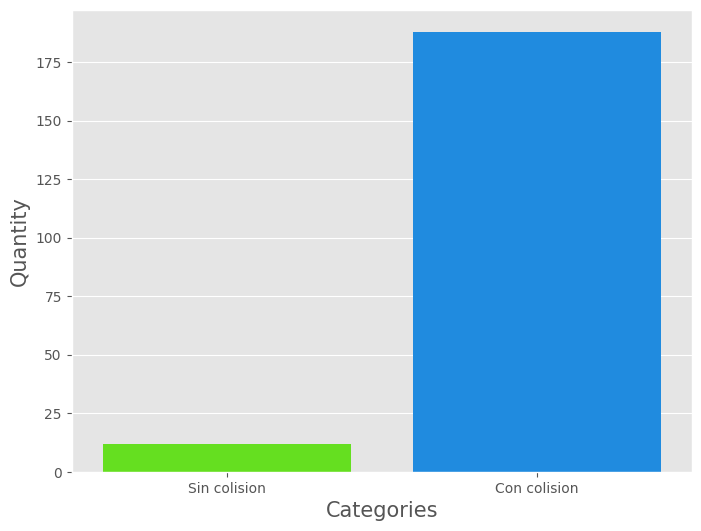

In [139]:
# Defining the plotsize
plt.figure(figsize=(8, 6))

# Defining the x-axis, the y-axis and the data
# from where the values are to be taken
plots = sns.barplot(x="Sequences", y="Cantidad", data=df, palette='gist_rainbow')

# Setting the x-acis label and its size
plt.xlabel("Categories", size=15)

# Setting the y-axis label and its size
plt.ylabel("Quantity", size=15)

# Finallt plotting the graph
plt.show()


In [93]:
import random

In [94]:
plot_successful = {}
for seq in successful_sequences:
    sequence = combinations[seq]
    total_time = 0
    for robot_name, welds in sequence.items():
        if robot_name == "R1":
            welds_time = weld_time_R1 
        else:
            welds_time = weld_time_R2
        for weld in welds:
            total_time += welds_time[weld] * random.choices([1.1, 4.3, 5.6, 2.6, 3.9, 5.5], k = 1)[0]
    plot_successful[seq] = np.round(total_time, 3)


In [95]:
plot_successful

{'c4': 20.034,
 'c11': 19.007,
 'c32': 20.712,
 'c49': 18.554,
 'c55': 18.081,
 'c105': 19.636,
 'c133': 18.797,
 'c137': 17.926,
 'c144': 20.393,
 'c166': 19.073,
 'c168': 18.169,
 'c196': 17.722}

In [96]:
# Creating our own dataframe
data = {"Sequences":list(plot_successful.keys()),
        "Time": list(plot_successful.values())}

df = pd.DataFrame(data, columns=['Sequences', 'Time'])

In [107]:
sns.hls_palette(h=.5)

[(0.33999999999999997, 0.8599999999999999, 0.86),
 (0.33999999999999997, 0.33999999999999997, 0.86),
 (0.8599999999999995, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.33999999999999997),
 (0.86, 0.8599999999999995, 0.33999999999999997),
 (0.3400000000000003, 0.86, 0.33999999999999997)]

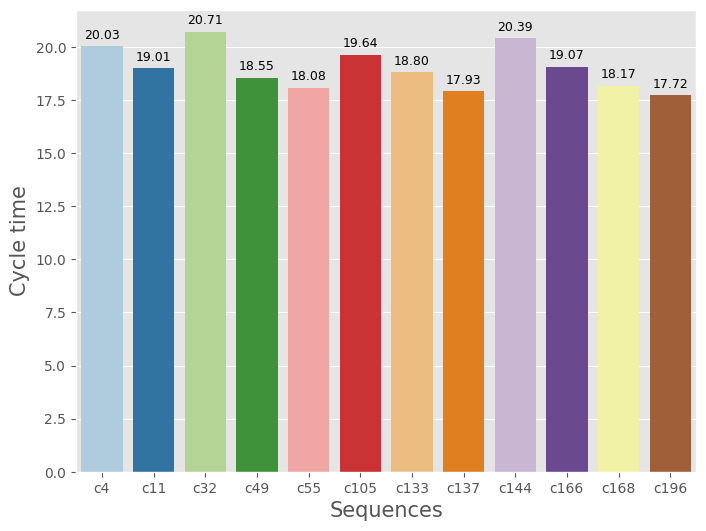

In [115]:
plt.figure(figsize=(8, 6))
plots = sns.barplot(x="Sequences", y="Time", data=df, palette='Paired')

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
    (bar.get_x() + bar.get_width() / 2,
    bar.get_height()), ha='center', va='center',
    size=9, xytext=(0, 8),
    textcoords='offset points')
plt.xlabel("Sequences", size=15)

plt.ylabel("Cycle time", size=15)

plt.show()